In [1]:
import numpy as np

ndata = 10000
lbox = 1000 #Mpc

data = lbox*np.random.rand(ndata,3)

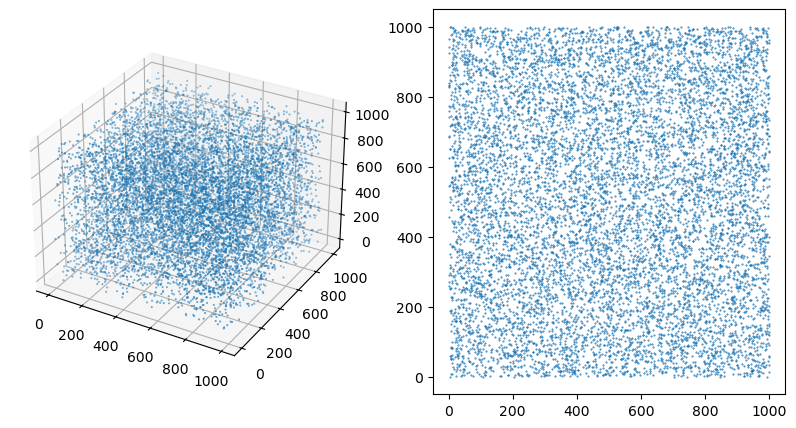

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)


ax1.scatter(xs=data[:,0],ys=data[:,1],zs=data[:,2],s=.2)
ax2.scatter(data[:,0],data[:,1],s=.2)
plt.show()

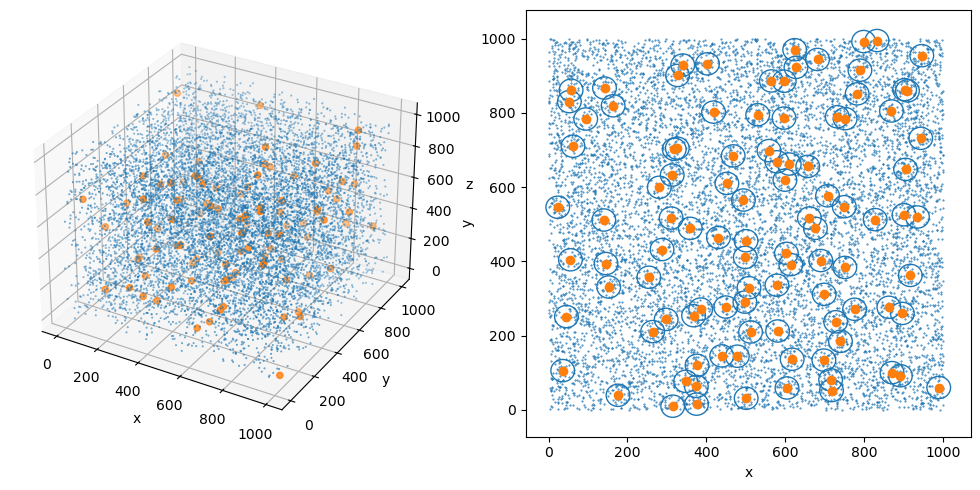

In [3]:
nsph = 100
sph = lbox*np.random.rand(nsph,3)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)


from matplotlib.patches import Circle

radius = 30
for i in range(nsph):
    circle = Circle((sph[:,0][i],sph[:,1][i]), radius,ec='C00',fc='none')
    ax2.add_patch(circle)

ax1.scatter(xs=data[:,0],ys=data[:,1],zs=data[:,2],s=.2)
ax1.scatter(xs=sph[:,0],ys=sph[:,1],zs=sph[:,2])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax2.scatter(data[:,0],data[:,1],s=.2)
ax2.scatter(sph[:,0],sph[:,1])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.tight_layout()
plt.show()

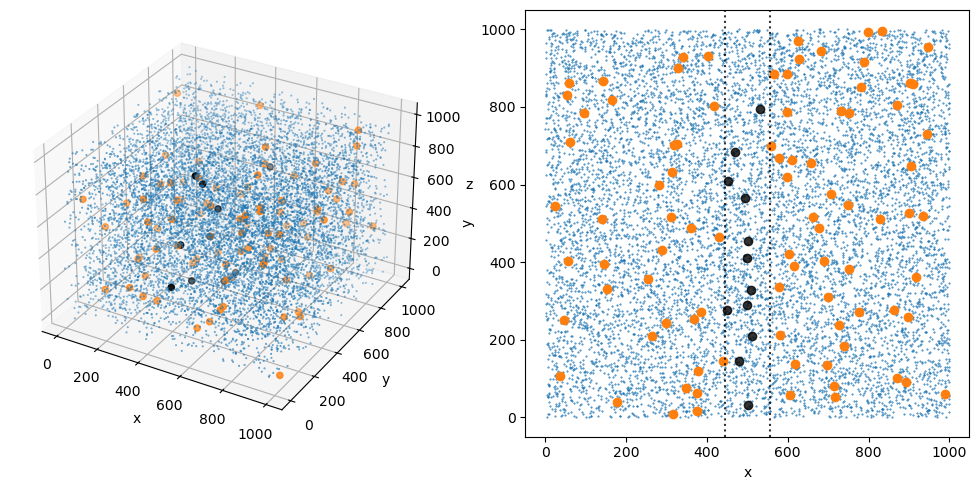

In [4]:
rmin, rmax = 3., 90.
rbins = 10
rs = np.linspace(rmin,rmax,rbins)

njk = 10 #N. of Jackknifes
jackk_bins = np.linspace(0,lbox,njk)
i=4
mask2 = (sph[:,0] < jackk_bins[i+1])
mask1 = (sph[:,0] > jackk_bins[i])        
mask_inv = np.logical_and(mask1,mask2)

mask = np.invert(mask_inv)
sph_no = sph[mask_inv,:]
sph_yes = sph[mask,:]
#sph = sph[:n]


fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)


from matplotlib.patches import Circle

# radius = 30
# for i in range(nsph):
#     circle = Circle((sph[:,0][i],sph[:,1][i]), radius,ec='C00',fc='none')
#     ax2.add_patch(circle)

ax1.scatter(xs=data[:,0],ys=data[:,1],zs=data[:,2],s=.2)
ax1.scatter(xs=sph_no[:,0],ys=sph_no[:,1],zs=sph_no[:,2],c='k')
ax1.scatter(xs=sph_yes[:,0],ys=sph_yes[:,1],zs=sph_yes[:,2])

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax2.scatter(data[:,0],data[:,1],s=.2)
ax2.scatter(sph_no[:,0],sph_no[:,1],c='k',alpha=.8)
ax2.scatter(sph_yes[:,0],sph_yes[:,1])
ax2.axvline(jackk_bins[i],ls=':',c='k',alpha=.8)
ax2.axvline(jackk_bins[i+1],ls=':',c='k',alpha=.8)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.tight_layout()
plt.show()

/tmp/ipykernel_6830/3589692054.py:63: RuntimeWarning: invalid value encountered in scalar divide
  xi_jk[i][j] = (np.mean((ngal-N_mean_jk[i][j])**2)-N_mean_jk[i][j])/N_mean_jk[i][j]**2
/tmp/ipykernel_6830/3589692054.py:72: RuntimeWarning: divide by zero encountered in log
  chi = -np.log(P0)/N_mean
/tmp/ipykernel_6830/3589692054.py:72: RuntimeWarning: invalid value encountered in divide
  chi = -np.log(P0)/N_mean
/tmp/ipykernel_6830/3589692054.py:30: RuntimeWarning: divide by zero encountered in log
  return chi*abs(P0err/(P0*abs(np.log(P0)))-N_mean_std/N_mean)
/tmp/ipykernel_6830/3589692054.py:30: RuntimeWarning: invalid value encountered in multiply
  return chi*abs(P0err/(P0*abs(np.log(P0)))-N_mean_std/N_mean)
/tmp/ipykernel_6830/3589692054.py:30: RuntimeWarning: invalid value encountered in divide
  return chi*abs(P0err/(P0*abs(np.log(P0)))-N_mean_std/N_mean)


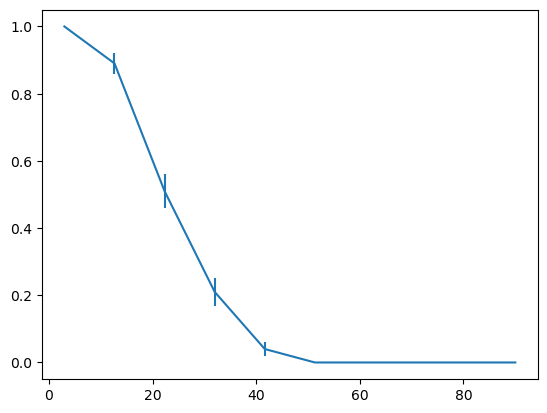

In [5]:
def delta_P0(P0,Nran):
    """Calculates error for P0 as derived in Colombi et al 1995
    Args:

        P0(numpy array): value(s) of P0
        Nran(numpy array): number of volume samples in the data

    Returns:
        aray: uncertainty of P0
    """

    import numpy as np
    return np.sqrt(P0*(1-P0)/Nran)

def delta_chi(chi,P0,P0err,N_mean,N_mean_std):
    """Calculates error for chi as derived in Colombi et al 1995 (Fry et al 2013)
    Args:

        chi(numpy array): value(s) of chi
        P0(numpy array): value(s) of P0
        P0err (numpy array): delta P0
        N_mean(numpy array): mean number of objects in volume(r)
        N_mean_std(numpy array): uncertainty of N_mean calculated with JK resampling

    Returns:
        array: uncertainty of chi
    """
    import numpy as np

    return chi*abs(P0err/(P0*abs(np.log(P0)))-N_mean_std/N_mean)

from scipy import spatial

rmin, rmax = 3., 90.
rbins = 10
rs = np.linspace(rmin,rmax,rbins)

njk = 10 #N. of Jackknifes
jackk_bins = np.linspace(0,lbox,njk+1)

data_tree = spatial.cKDTree(data)

N_mean_jk = np.zeros((njk,rbins))
N_var_jk = np.zeros((njk,rbins))
P0_jk = np.zeros((njk,rbins))
xi_jk = np.zeros((njk,rbins))

for i in range(njk):
    mask2 = (sph[:,0] < jackk_bins[i+1])
    mask1 = (sph[:,0] > jackk_bins[i])        
    mask_inv = np.logical_and(mask1,mask2)

    mask = np.invert(mask_inv)
    sph_yes = sph[mask,:]

    for j in range(rbins):

        ngal = data_tree.query_ball_point(sph_yes,rs[j],return_length=True)

        P0_jk[i][j] = len(np.where(ngal==0)[0])/len(sph_yes)   
        N_mean_jk[i][j] = np.mean(ngal)
        N_var_jk[i][j] = np.var(ngal,ddof=1)/njk
        xi_jk[i][j] = (np.mean((ngal-N_mean_jk[i][j])**2)-N_mean_jk[i][j])/N_mean_jk[i][j]**2

#<N>
N_mean = np.mean(N_mean_jk,axis=0)
N_var = np.mean(N_var_jk,axis=0)
#P0
P0 = np.mean(P0_jk,axis=0)
P0_var = np.var(P0_jk,axis=0,ddof=1)/njk
#chi
chi = -np.log(P0)/N_mean
chi_std = delta_chi(chi,P0,P0_var,N_mean,np.sqrt(N_var))
#xi
xi = np.mean(xi_jk,axis=0)


#print(P0_jk)
#print(np.mean(P0_jk,axis=0))

plt.errorbar(rs,P0,yerr=delta_P0(P0,nsph))
plt.show()



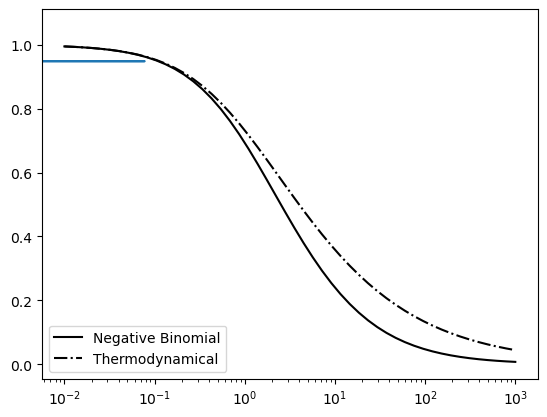

In [6]:
#PLOT
x = np.geomspace(1E-2,1E3,50)
c='k'
plt.plot(x,np.log(1+x)/x,label='Negative Binomial',c=c)
plt.plot(x,(np.sqrt(1+2*x)-1)/x,label='Thermodynamical',c=c,ls='-.')

#chiCF = -np.log(p0CF)/nmean
#nxiCF = nmean*xi
#print(chiCF)
#print(chi)
plt.plot(xi*N_mean,chi,c='C00')
plt.xscale('log')
plt.legend(loc=3)
plt.show()


[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


0.98
0.84
0.52
0.12
0.03
0.0
0.0
0.0
0.0
0.0


[]

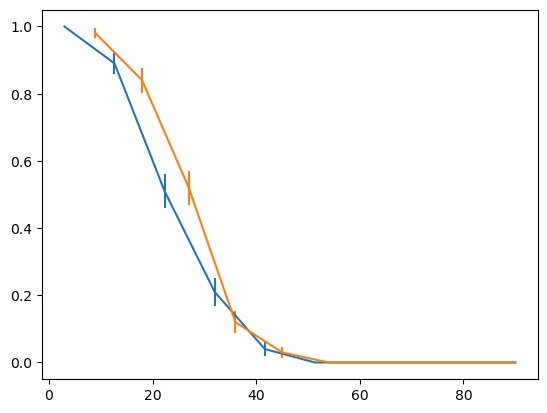

In [7]:
from Corrfunc.theory.vpf import vpf
numpN=2
seed=42
results_vpf = vpf(rmax, rbins, nsph, numpN=numpN, seed=seed, X=data[:,0], Y=data[:,1], Z=data[:,2], boxsize=lbox)

rnew=np.zeros(rbins)
p0new=np.zeros(rbins)
for i in range(len(results_vpf)):
    print(results_vpf[i][1][0])
    rnew[i]=results_vpf[i][0]
    p0new[i]=results_vpf[i][1][0]

plt.errorbar(rs,P0,yerr=np.sqrt(P0*(1-P0)/nsph))
plt.errorbar(rnew,p0new,yerr=np.sqrt(p0new*(1-p0new)/nsph))
plt.plot()

In [2]:
import numpy as np
import readgadget
import readfof

#-----------
# Read data from Quijote
#-----------
#
snapdir = '/home/fdavilakurban/mnt/clemente/quijote/Halos/FoF/fiducial/0/' #folder hosting the catalogue
snapnum = 4   
# get the name of the corresponding snapshot
snapshot = '/home/fdavilakurban/mnt/clemente/quijote/Snapshots/fiducial/0/snapdir_%03d/snap_%03d'%(snapnum,snapnum)

# read the redshift, boxsize, cosmology...etc in the header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

print('BoxSize = %.3f Mpc/h'%BoxSize)
#print('Number of particles in the snapshot:',Nall)
#print('Omega_m = %.3f'%Omega_m)
#print('Omega_l = %.3f'%Omega_l)
#print('h = %.3f'%h)
print('redshift = %.1f'%redshift)

# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False,
                          swap=False, SFR=False, read_IDs=False)
# get the properties of the halos
gxs = FoF.GroupPos/1e3  #Halo positions in Mpc/h

BoxSize = 1000.000 Mpc/h
redshift = 0.0


0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
[0.90052315 0.85527795 0.7995678  0.73456885 0.66458047 0.59249882
 0.52015677 0.45210365 0.38815667 0.3331601 ]
[0.00950517 0.00707164 0.00483214 0.00346434 0.00279765 0.00191332
 0.00151511 0.00137077 0.0013886  0.00198294]


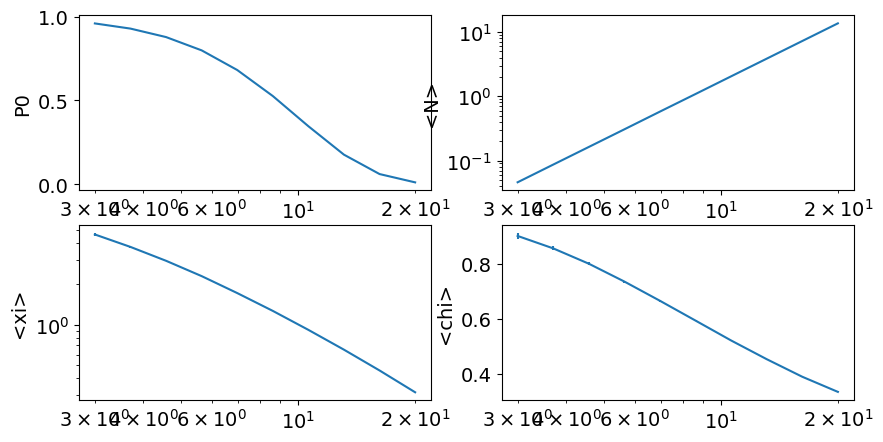

In [74]:
def delta_P0(P0,Nran):
    """Calculates error for P0 as derived in Colombi et al 1995
    Args:

        P0(numpy array): value(s) of P0
        Nran(numpy array): number of volume samples in the data

    Returns:
        aray: uncertainty of P0
    """

    import numpy as np
    return np.sqrt(P0*(1-P0)/Nran)

def delta_chi(chi,P0,P0err,N_mean,N_mean_std):
    """Calculates error for chi as derived in Colombi et al 1995 (Fry et al 2013)
    Args:

        chi(numpy array): value(s) of chi
        P0(numpy array): value(s) of P0
        P0err (numpy array): delta P0
        N_mean(numpy array): mean number of objects in volume(r)
        N_mean_std(numpy array): uncertainty of N_mean calculated with JK resampling

    Returns:
        array: uncertainty of chi
    """
    import numpy as np

    return chi*abs(P0err/(P0*abs(np.log(P0)))-N_mean_std/N_mean)

from scipy import spatial
from cicTools import *

# Basic Parameters
rmin, rmax = 3., 20. #Mpc
rbins = 10
rs = np.geomspace(rmin,rmax,rbins)
lbox = BoxSize

# Jackknife Parameters
njk = 10 #N. of Jackknifes
jackk_bins = np.linspace(0,lbox,njk+1)

newgxs = perrep_array(gxs,lbox,rmax)

data_tree = spatial.cKDTree(newgxs)

# Probing Spheres
nsph = 100000
sph = lbox*np.random.rand(nsph,3)

# Calculations
N_mean_jk = np.zeros((njk,rbins))
#N_var_jk = np.zeros((njk,rbins))
P0_jk = np.zeros((njk,rbins))
xi_jk = np.zeros((njk,rbins))

sph = lbox*np.random.rand(njk,nsph,3)


for i in range(njk):
    print(i,'/',njk)
    mask2 = (sph[i][:,0] < jackk_bins[i+1])
    mask1 = (sph[i][:,0] > jackk_bins[i])        
    mask_inv = np.logical_and(mask1,mask2)

    mask = np.invert(mask_inv)
    sph_yes = sph[i][mask,:]
    
    for j in range(rbins):
        ngal = data_tree.query_ball_point(sph_yes,rs[j],return_length=True)

        P0_jk[i][j] = len(np.where(ngal==0)[0])/len(sph_yes)
        #print(np.mean(ngal))
        N_mean_jk[i][j] = np.mean(ngal)
        #N_var_jk[i][j] = np.var(ngal,ddof=1)/njk
        xi_jk[i][j] = (np.mean((ngal-N_mean_jk[i][j])**2)-N_mean_jk[i][j])/N_mean_jk[i][j]**2



#<N>
N_mean = np.mean(N_mean_jk,axis=0)
N_mean_var = np.var(N_mean_jk,axis=0,ddof=1)/njk
#P0
P0 = np.mean(P0_jk,axis=0)
P0_var = np.var(P0_jk,axis=0,ddof=1)/njk
#chi
chi = -np.log(P0, out=np.zeros_like(P0), where=(P0!=0))/N_mean
chi[chi==0] = np.nan
chi_std = delta_chi(chi,P0,delta_P0(P0,nsph),N_mean,np.sqrt(N_mean_var))
#xi
xi = np.mean(xi_jk,axis=0)
xi_var = np.var(xi_jk,axis=0,ddof=1)/njk

print(chi)
print(chi_std)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.errorbar(rs,P0,yerr=np.sqrt(P0*(1-P0)/nsph))
ax1.set_ylabel('P0')
ax2.errorbar(rs,N_mean,yerr=np.sqrt(N_mean_var))
ax2.set_ylabel('<N>')
ax3.errorbar(rs,xi,yerr=np.sqrt(xi_var))
ax3.set_ylabel('<xi>')
ax4.errorbar(rs,chi,yerr=chi_std)
ax4.set_ylabel('<chi>')
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')

[0.01044073 0.00620096 0.00493447 0.00354576 0.00248759 0.00195655
 0.00166145 0.00130755 0.00138897 0.00200718]


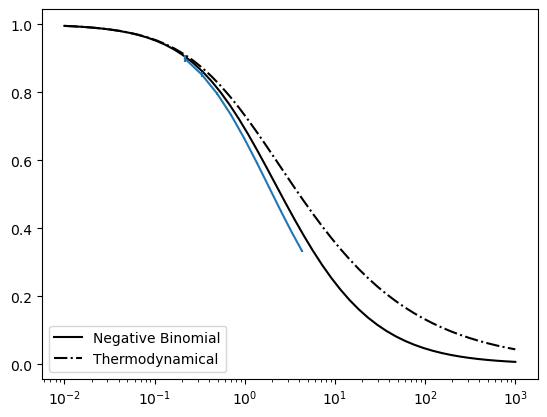

In [70]:
print(chi_std)
#chi_std = delta_chi(chi,P0,delta_P0(P0,nsph),N_mean,np.sqrt(N_var))

#PLOT
x = np.geomspace(1E-2,1E3,50)
c='k'
plt.plot(x,np.log(1+x)/x,label='Negative Binomial',c=c)
plt.plot(x,(np.sqrt(1+2*x)-1)/x,label='Thermodynamical',c=c,ls='-.')

#chiCF = -np.log(p0CF)/nmean
#nxiCF = nmean*xi
#print(chiCF)
#print(chi)
a=0
plt.errorbar(xi[:]*N_mean[:],chi[:],yerr=chi_std[:],c='C00')
plt.xscale('log')
plt.legend(loc=3)
plt.show()



### codigo usual

In [71]:
from cicTools import *

chi = np.zeros(len(rs))
NXi = np.zeros(len(rs))
P0 = np.zeros(len(rs))
N_mean = np.zeros(len(rs))
xi_mean = np.zeros(len(rs))

chi_std = np.zeros(len(rs))
NXi_std = np.zeros(len(rs))
P0_std = np.zeros(len(rs))
N_mean_std = np.zeros(len(rs))
xi_mean_std = np.zeros(len(rs))

print('Calculating JK cic statistics...')

for i,r in enumerate(rs):
    chi[i], NXi[i], P0[i], N_mean[i], xi_mean[i],\
            chi_std[i], NXi_std[i], P0_std[i], N_mean_std[i], xi_mean_std[i]\
                = cic_stats_jk_try(data_tree, nsph, r, lbox, njk)

Calculating JK cic statistics...


[0.00152195 0.00118552 0.00087757 0.00045471 0.00090899 0.00044004
 0.00052129 0.00059729 0.0004936  0.00076961]


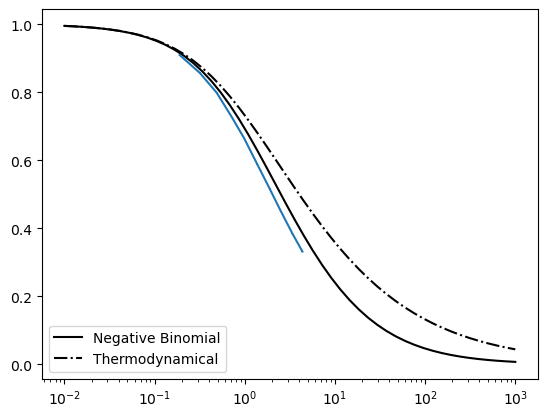

In [72]:
print(chi_std)
#chi_std = delta_chi(chi,P0,delta_P0(P0,nsph),N_mean,np.sqrt(N_var))

#PLOT
x = np.geomspace(1E-2,1E3,50)
c='k'
plt.plot(x,np.log(1+x)/x,label='Negative Binomial',c=c)
plt.plot(x,(np.sqrt(1+2*x)-1)/x,label='Thermodynamical',c=c,ls='-.')

#chiCF = -np.log(p0CF)/nmean
#nxiCF = nmean*xi
#print(chiCF)
#print(chi)
a=0
plt.errorbar(NXi,chi,yerr=chi_std,c='C00')
plt.xscale('log')
plt.legend(loc=3)
plt.show()



### Stability

In [55]:
def delta_P0(P0,Nran):
    """Calculates error for P0 as derived in Colombi et al 1995
    Args:

        P0(numpy array): value(s) of P0
        Nran(numpy array): number of volume samples in the data

    Returns:
        aray: uncertainty of P0
    """

    import numpy as np
    return np.sqrt(P0*(1-P0)/Nran)

def delta_chi(chi,P0,P0err,N_mean,N_mean_std):
    """Calculates error for chi as derived in Colombi et al 1995 (Fry et al 2013)
    Args:

        chi(numpy array): value(s) of chi
        P0(numpy array): value(s) of P0
        P0err (numpy array): delta P0
        N_mean(numpy array): mean number of objects in volume(r)
        N_mean_std(numpy array): uncertainty of N_mean calculated with JK resampling

    Returns:
        array: uncertainty of chi
    """
    import numpy as np

    return chi*abs(P0err/(P0*abs(np.log(P0)))-N_mean_std/N_mean)

def vpf_new(rmin,rmax,rbins,njk,nsph,BoxSize,gxs):

    from scipy import spatial
    from cicTools import delta_chi, delta_P0, perrep_array

    # Basic Parameters
    #rmin, rmax = 3., 20. #Mpc
    #rbins = 10
    rs = np.geomspace(rmin,rmax,rbins)
    lbox = BoxSize

    # Jackknife Parameters
    njk = 10 #N. of Jackknifes
    jackk_bins = np.linspace(0,lbox,njk+1)

    newgxs = perrep_array(gxs,lbox,rmax)

    data_tree = spatial.cKDTree(newgxs)

    # Probing Spheres
    nsph = 100000
    sph = lbox*np.random.rand(nsph,3)

    # Calculations
    N_mean_jk = np.zeros((njk,rbins))
    #N_var_jk = np.zeros((njk,rbins))
    P0_jk = np.zeros((njk,rbins))
    xi_jk = np.zeros((njk,rbins))

    sph = lbox*np.random.rand(njk,nsph,3)


    for i in range(njk):
        print(i,'/',njk)
        mask2 = (sph[i][:,0] < jackk_bins[i+1])
        mask1 = (sph[i][:,0] > jackk_bins[i])        
        mask_inv = np.logical_and(mask1,mask2)

        mask = np.invert(mask_inv)
        sph_yes = sph[i][mask,:]
        
        for j in range(rbins):
            ngal = data_tree.query_ball_point(sph_yes,rs[j],return_length=True)

            P0_jk[i][j] = len(np.where(ngal==0)[0])/len(sph_yes)
            #print(np.mean(ngal))
            N_mean_jk[i][j] = np.mean(ngal)
            #N_var_jk[i][j] = np.var(ngal,ddof=1)/njk
            xi_jk[i][j] = (np.mean((ngal-N_mean_jk[i][j])**2)-N_mean_jk[i][j])/N_mean_jk[i][j]**2



    #<N>
    N_mean = np.mean(N_mean_jk,axis=0)
    N_mean_var = np.var(N_mean_jk,axis=0,ddof=1)/njk
    #P0
    P0 = np.mean(P0_jk,axis=0)
    #P0_var = np.var(P0_jk,axis=0,ddof=1)/njk
    #chi
    chi = -np.log(P0, out=np.zeros_like(P0), where=(P0!=0))/N_mean
    chi[chi==0] = np.nan
    chi_std = delta_chi(chi,P0,delta_P0(P0,nsph),N_mean,np.sqrt(N_mean_var))
    #xi
    xi = np.mean(xi_jk,axis=0)
    xi_var = np.var(xi_jk,axis=0,ddof=1)/njk

    return N_mean, N_mean_var, P0, chi, chi_std, xi, xi_var


ni, nf, nbin = 1000, 1000000, 4
ns = np.geomspace(ni, nf, nbin).astype(int)
rbin = 8
rmin, rmax = 3., 25.
njk = 10

N_mean = np.zeros((nbin,rbin))
N_mean_var = np.zeros((nbin,rbin))
P0 = np.zeros((nbin,rbin))
chi = np.zeros((nbin,rbin))
chi_std = np.zeros((nbin,rbin))
xi = np.zeros((nbin,rbin))
xi_var = np.zeros((nbin,rbin))

for i,n in zip(range(nbin),ns):
    print('ns =',n)
    N_mean[i], N_mean_var[i], P0[i], chi[i], chi_std[i], xi[i], xi_var[i] = vpf_new(rmin,rmax,rbin,njk,n,BoxSize,gxs)

ns = 1000
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
ns = 10000
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
ns = 100000
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
ns = 1000000
0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


In [50]:
print(r)

8.870053709241581


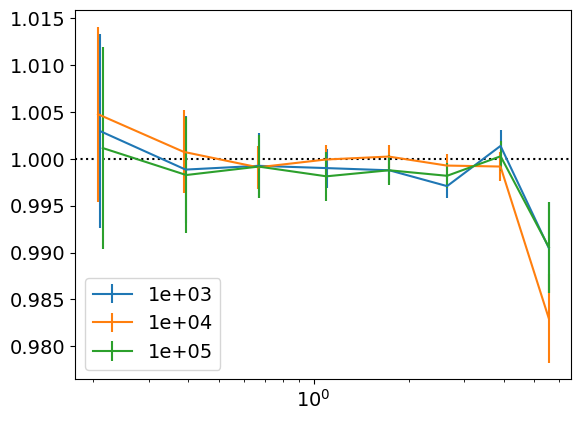

In [73]:


#PLOT
x = np.geomspace(1E-2,1E3,50)
c='k'
#plt.plot(x,(np.log(1+x)/x)/(np.log(1+x)/x),label='Negative Binomial',c=c)
#plt.plot(x,((np.sqrt(1+2*x)-1)/x)/(np.log(1+x)/x),label='Thermodynamical',c=c,ls='-.')
plt.axhline(1,c='k',ls=':')

for i in range(nbin-1):
    xdata = xi[i]*N_mean[i]
    ydata = chi[i]/chi[-1]
    plt.errorbar(xdata,ydata,yerr=chi_std[i],label=f'{ns[i]:.0e}')
plt.xscale('log')
plt.legend(loc=3)
plt.show()

